# Real estate ROI calculator 

## Configurables
Change your url and location here

In [1]:
#Replace this url with the url of your search results
#url = 'https://www.immobilienscout24.de/Suche/de/berlin/berlin/wohnung-kaufen?enteredFrom=one_step_search'
# TODO concatenate url with region and city
# state = "sachsen-anhalt"
# city = "magdeburg"
url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/rheinland-pfalz/alzey-worms-kreis/wohnung-kaufen?enteredFrom=result_list'
file_name_csv_raw = 'immobilienscout_result.csv'

# Your variables to change
rent_price_index = 11
equity_percentage = 0.2
interest_rate = 0.01
mortgage_payment_rate = 0.02

# Standard percentages
notary_percentage = 0.015
transfer_tax_percentage = 0.05
land_registry_tax_percentage = 0.005
additional_costs_rate_per_m2 = 0.9 

## Setup

In [2]:
import urllib.request
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy import Selector
import selenium
from selenium import webdriver
import chromedriver_binary
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 200)

import json
import re
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:

columns = ['id_expose', 'url', 'title', 'address', 'contact_person', 'telephone', 'mobile', 'fax', 'price_purchase', 'estimated_monthly_rate', 'rooms', 'living_area_m2', 'furnishing', 'flat_type', 'floor', 'floor_total', 'bedrooms', 'commission_buyer_rate', 'maintenance_cost', 'construction_year', 'object_state', 'heating_type', 'energy_efficiency_class', 'location']

df_base = pd.DataFrame(columns = columns)

options = Options()
options.headless = True

crawler_name = 'scrapper_immobilienscout'

base_uri = 'immobilienscout24.de'
base_url = 'https://www.immobilienscout24.de'

In [4]:
driver = webdriver.Chrome()
# OLD configuration
#driver = webdriver.Chrome(options=options, executable_path="chromedriver.exe")

class Scrap_immobilienscout(scrapy.Spider):
    
    name = crawler_name
    
    def start_requests(self):
        first_page = urllib.request.urlopen(url_to_crawl)
        max_pages = first_page.read()
        max_pages = max_pages.decode("utf8")
        first_page.close()

        max_pages_selector = Selector(text = max_pages)
        max_pages = max_pages_selector.xpath('//select[@aria-label="Seitenauswahl"]/option[last()]/@value').extract_first()
        max_pages = int(max_pages) if max_pages is not None else 1
        
        base_url = url_to_crawl.replace('enteredFrom=one_step_search', '')
        
        for page_number in range(max_pages):
            url = base_url + 'pagenumber=' + str(page_number + 1)
            yield scrapy.Request(url, callback = self.parse_properties_list)
    
    def parse_properties_list(self, response):
        
        property_urls = response.xpath('//a[contains(@class, "result-list-entry__brand-title-container")]/@href').extract()
        
        for url in property_urls:
            if base_uri not in url:
                url = base_url + url + '#/'
                driver.get(url)
                src = driver.page_source
                self.scrap_property(src, url)
    
    # TODO rename variables
    # TODO clarify default values
    # TODO fix parse issues (int, roundings, etc.)
    def scrap_property(self, src, url):
        sel = Selector(text = src)

        id_expose = '' # TODO get expose substring of url
        
        title = sel.css('h1#expose-title ::text').extract_first()
        
        address = sel.xpath('//div[@class="address-block"]//span[@class="block font-nowrap print-hide"]//text()').extract_first()
        address = address.strip() if address is not None else ''

        region = sel.css('span.zip-region-and-country::text').extract_first()
        address += ' ' + region if region is not None else ''
        
        contact_person = sel.xpath('//div[@data-qa="contactName"]//text()').extract_first()
        contact_person = contact_person if contact_person is not None else ''
        
        phone = sel.xpath('//script//text()').extract_first()
        phone = phone if phone is not None else ''

        telefon = re.findall('"phoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        telefon = telefon[0].replace(' ', '') if len(telefon) > 0 else None
        
        mobil = re.findall('"cellPhoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        mobil = mobil[0] if len(mobil) > 0 else ''
        mobil = mobil.replace(' ', '')

        fax = re.findall('"faxNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        fax = fax[0] if len(fax) > 0 else ''
        fax = fax.replace(' ', '')
        
        price = sel.xpath('//dd[contains(@class, "is24qa-kaufpreis")]//text()').extract_first()
        price = re.sub('[^0-9]', '', price) if price is not None else 0
        price = int(price)
        
        estimated_monthly_rate = sel.xpath('//span[contains(@class, "monthly-rate-result") and contains(@class, "monthly-rate-value")]//text()').extract_first()
        estimated_monthly_rate = re.sub('[^0-9]', '', estimated_monthly_rate) if estimated_monthly_rate is not None else 0
        estimated_monthly_rate = int(estimated_monthly_rate)
        
        rooms_count = sel.xpath('//dd[contains(@class,"is24qa-zimmer")]/text()').extract_first()
        rooms_count = float(rooms_count.replace(" ","").replace(",",".") ) if rooms_count is not None else 0
        
        living_area = sel.xpath('//dd[contains(@class, "is24qa-wohnflaeche-ca")]/text()').extract_first()
        living_area = re.sub('[^0-9\.]', '', living_area.replace(",",".")) if living_area is not None else 0
        living_area = float(living_area)
        
        furnishing = sel.xpath('//div[contains(@class, "criteriagroup") and contains(@class, "boolean-listing")]//span[contains(@class, "palm-hide")]/text()').extract()
        furnishing = list(set(furnishing))
        furnishing = [t for t in furnishing if t != ' ']
        furnishing = furnishing if len(furnishing) > 0 else ''
        
        flat_type = sel.xpath('//dd[contains(@class, "is24qa-typ")]/text()').extract_first()
        
        floor = sel.xpath('//dd[contains(@class, "is24qa-etage")]//text()').extract_first()
        floor = floor if floor is not None else ''
        floor = re.findall('[0-9]+', floor)
        total_floors = int(floor[1]) if len(floor) > 1 else 0
        floor = int(floor[0]) if len(floor) > 0 else 0
        
        bedroom = sel.xpath('//dd[contains(@class, "is24qa-schlafzimmer")]//text()').extract_first()
        bedroom = re.sub('[^0-9]', '', bedroom) if bedroom is not None else 0
        bedroom = int(bedroom)
        
        allowance = sel.xpath('//dd[contains(@class, "is24qa-hausgeld")]//text()').extract_first()
        allowance = re.sub('[^0-9]', '', allowance) if allowance is not None else 0
        allowance = int(allowance)
        
        commission = sel.xpath('//dd[contains(@class, "is24qa-provision")]/text()').extract_first()
        
        if commission is not None:
            try:
                commission = re.search('[0-9]+,?[0-9]*', commission).group() 
            except:
                commission = ''
        else:
            commission = ''

        commission = commission.replace(',', '.')
        commission = float(commission) if len(commission) > 0 else 0
        
        construction_year = sel.xpath('//dd[contains(@class, "is24qa-baujahr")]//text()').extract_first()
        
        object_state = sel.xpath('//dd[contains(@class, "is24qa-objektzustand")]//text()').extract_first()
        
        heatingy_type = sel.xpath('//dd[contains(@class, "is24qa-heizungsart")]//text()').extract_first()
        
        energy_efficiency_class = sel.xpath('//dd[contains(@class, "is24qa-energieeffizienzklasse")]//text()').extract_first()
        energy_efficiency_class = energy_efficiency_class if energy_efficiency_class is not None else ''
        
        location = sel.xpath('//pre[contains(@class, "is24qa-lage")]/text()').extract_first()

        lst_row = [id_expose, url, title, address, contact_person, telefon, mobil, fax, price, estimated_monthly_rate, rooms_count, living_area, furnishing, flat_type, floor, total_floors, bedroom, commission, allowance, construction_year, object_state, heatingy_type, energy_efficiency_class, location]
        df_base.loc[len(df_base)] = lst_row
        df_base.to_csv(file_name_csv_raw, index=False)
        
process = CrawlerProcess()
process.crawl(Scrap_immobilienscout)
process.start()
# TODO unblock process. See: https://docs.scrapy.org/en/latest/topics/practices.html 

://127.0.0.1:51494/session/188b1b2166ef282d596bec9fdecd7cf2/url {"url": "https://www.immobilienscout24.de/expose/112823147#/"}
2020-07-19 14:34:09 [urllib3.connectionpool] DEBUG: http://127.0.0.1:51494 "POST /session/188b1b2166ef282d596bec9fdecd7cf2/url HTTP/1.1" 200 14
2020-07-19 14:34:09 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-19 14:34:09 [selenium.webdriver.remote.remote_connection] DEBUG: GET http://127.0.0.1:51494/session/188b1b2166ef282d596bec9fdecd7cf2/source {}
2020-07-19 14:34:09 [urllib3.connectionpool] DEBUG: http://127.0.0.1:51494 "GET /session/188b1b2166ef282d596bec9fdecd7cf2/source HTTP/1.1" 200 817796
2020-07-19 14:34:09 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-19 14:34:10 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:51494/session/188b1b2166ef282d596bec9fdecd7cf2/url {"url": "https://www.immobilienscout24.de/expose/112823144#/"}
2020-07-19 14:34:10 [urllib3.connection

In [5]:
# Write (parse) to CSV again
df_base.to_csv(file_name_csv_raw, index=False)

In [6]:
# Read CSV again
df_base = pd.read_csv(file_name_csv_raw)

## Exploration

In [7]:
# dataframe dimensions
df_base.shape

(32, 24)

In [8]:
# column datatypes
df_base.dtypes

id_expose                  float64
url                         object
title                       object
address                     object
contact_person              object
telephone                  float64
mobile                     float64
fax                        float64
price_purchase               int64
estimated_monthly_rate       int64
rooms                      float64
living_area_m2             float64
furnishing                  object
flat_type                   object
floor                        int64
floor_total                  int64
bedrooms                     int64
commission_buyer_rate      float64
maintenance_cost             int64
construction_year           object
object_state                object
heating_type                object
energy_efficiency_class     object
location                    object
dtype: object

In [9]:
df_base.select_dtypes(include=['object']).isnull().sum()

url                         0
title                       0
address                     0
contact_person              0
furnishing                  0
flat_type                   8
construction_year           2
object_state               12
heating_type               12
energy_efficiency_class    14
location                    8
dtype: int64

In [10]:
df_base.head(10)
#df_base['url'][4]
#df[0:5]
#df.tail()

,id_expose,url,title,address,contact_person,telephone,mobile,fax,price_purchase,estimated_monthly_rate,rooms,living_area_m2,furnishing,flat_type,floor,floor_total,bedrooms,commission_buyer_rate,maintenance_cost,construction_year,object_state,heating_type,energy_efficiency_class,location
0,NaN,https://www.immobilienscout24.de/expose/120249137#/,"Lukrative Kapitalanlage mit 4,10 % Rendite ! Ideal für den Einstieg in die Immobilienanlage !","55232 Alzey-Heimersheim, Alzey",Herr Bernd Rees,6.142701e+10,1.520239e+10,NaN,297000,0,4.0,149.00,['Vermietet'],Hochparterre,0,0,0,5.80,0,1979,Gepflegt,Zentralheizung,D,"Der kleine Ort Heimersheim mit ca. 800 Einwohnern liegt beschaulich zwischen Weinbergen vor den Toren von Alzey im Herzen von Rheinhessen.\nDie Gemeinde liegt rund 2,5 Kilometer nordwestlich von A..."
1,NaN,https://www.immobilienscout24.de/expose/120652918#/,Hier können Sie sich Wohlfühlen. Entfalten Sie sich in den eigenen vier Wänden.,"67574 Osthofen, Alzey-Worms (Kreis)",Herr Hans-Joachim Frey,6.233326e+09,NaN,NaN,363289,0,3.0,197.00,"['Einbauküche', 'Balkon/ Terrasse', 'Keller']",Erdgeschosswohnung,0,0,0,4.99,0,1992,NaN,Zentralheizung,NaN,Die Stadt Osthofen liegt in der Verbandsgemeinde Wonnegau im rheinland-pfälzischen Landkreis Alzey-Worms. Sie wurde im Jahr 1970 zur Stadt erhoben und hat heute rund 9.000 Einwohner. Die bisher ve...
2,NaN,https://www.immobilienscout24.de/expose/117982582#/,Rarität : 4 – Zimmer Dachgeschoss – Wohnung in Jugendstil Villa !!,"55597 Wöllstein, Alzey-Worms (Kreis)",Herr Yannick Holl,6.241386e+10,1.768474e+10,6.241211e+10,159500,0,4.0,102.00,"['Gäste-WC', 'Vermietet', 'Keller']",Dachgeschoss,3,3,3,5.95,325,1900,Gepflegt,Gas-Heizung,NaN,Wöllstein liegt im Westteil von Rheinhessen zwischen den Städten Bad Kreuznach und Alzey sowie den Dörfern Frei – Laubersheim und Gau – Bickelheim . Die Immobilie liegt in einer verkehrsberuhigten...
3,NaN,https://www.immobilienscout24.de/expose/118998113#/,Schicke 3 Zimmer DG mit 2 Bädern in kleiner Eigentümergemeinschaft,"55286 Wörrstadt, Alzey-Worms (Kreis)",Herr Frank Lahr,6.734963e+10,1.704627e+09,6.734963e+10,187000,0,3.0,77.94,"['Online-Besichtigung möglich', 'Gäste-WC', 'Einbauküche', 'Keller']",Dachgeschoss,2,3,2,5.80,160,1988,Modernisiert,Etagenheizung,E,"Wörrstadt ist eine Verbandsgemeinde in Rheinhessen an der BAB 63 -nach Mainz sind es knapp 21 km, nach Alzey ca. 15 km- und verfügt über eine sehr gute Infrastruktur. \n\nKindergärten, Schulen, al..."
4,NaN,https://www.immobilienscout24.de/expose/119795442#/,4ZKBB Eigentumswohnung in guter Wohnlage,"55286 Wörrstadt, Alzey-Worms (Kreis)",Herr Eren Kocamis,6.136954e+10,NaN,6.136954e+10,207000,0,4.0,90.00,"['Vermietet', 'Balkon/ Terrasse']",Erdgeschosswohnung,0,0,3,5.95,260,1995,Gepflegt,Zentralheizung,D,"Die Stadt Wörrstadt mit seinem Ortsteil Rommersheim ist derzeit die größte der zur Verbandgemeinde gehörenden Gemeinde. Wörrstadt ist äußerst verkehrsgünstig gelegen, unmittelbar an der A63 (eigen..."
5,NaN,https://www.immobilienscout24.de/expose/119795412#/,Gut vermietete 4 ZKBB in guter Wohnlage,"55286 Wörrstadt, Alzey-Worms (Kreis)",Herr Eren Kocamis,6.136954e+10,NaN,6.136954e+10,210000,0,4.0,93.00,"['Vermietet', 'Balkon/ Terrasse']",Etagenwohnung,0,0,3,5.95,219,1995,Gepflegt,Zentralheizung,D,"Die Stadt Wörrstadt mit seinem Ortsteil Rommersheim ist derzeit die größte der zur Verbandgemeinde gehörenden Gemeinde. Wörrstadt ist äußerst verkehrsgünstig gelegen, unmittelbar an der A63 (eigen..."
6,NaN,https://www.immobilienscout24.de/expose/118931312#/,HEMING-IMMOBILIEN - Schöne Startup-Immobilie in Alzey!,"55232 Alzey, Alzey-Worms (Kreis)",Herr Carl Alexander Wegner,6.732941e+08,NaN,6.732941e+09,85000,0,1.0,36.00,"['Online-Besichtigung möglich', 'Vermietet', 'Balkon/ Terrasse', 'Keller']",Erdgeschosswohnung,0,0,0,6.00,0,1993,NaN,NaN,D,"Die Eigentumswohnung befindet sich, zentral gelegen, in der sympathischen Kreisstadt Alzey.Alzey hat eine hervorragende Infrastruktur und ist von der Lage her ein sehr be

In [11]:
# TODO transform into numerical values for historgrams
# df_base.hist(xrot=-45, figsize=(14,14))

In [12]:
df_base.describe()

,id_expose,telephone,mobile,fax,price_purchase,estimated_monthly_rate,rooms,living_area_m2,floor,floor_total,bedrooms,commission_buyer_rate,maintenance_cost
count,0.0,3.000000e+01,1.400000e+01,1.600000e+01,32.000000,32.0,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,NaN,5.282926e+10,5.956056e+09,5.718196e+10,217693.062500,0.0,3.125000,102.384375,0.562500,0.687500,1.375000,4.448750,98.500000
std,NaN,2.485804e+10,6.917677e+09,1.985734e+10,90230.316825,0.0,0.870669,37.083188,0.948258,1.229673,1.338029,2.245977,137.165311
min,NaN,6.732941e+08,1.704627e+09,6.732941e+09,85000.000000,0.0,1.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,6.131216e+10,1.755458e+09,6.136954e+10,154600.000000,0.0,3.000000,78.735000,0.000000,0.000000,0.000000,4.495000,0.000000
50%,NaN,6.142701e+10,1.794684e+09,6.300209e+10,202500.000000,0.0,3.000000,102.000000,0.000000,0.000000,1.500000,5.800000,0.000000
75%,NaN,6.731534e+10,1.185047e+10,6.731493e+10,295500.000000,0.0,4.000000,112.250000,1.000000,0.500000,3.000000,5.837500,220.750000
max,NaN,7.033693e+10,1.768474e+10,6.734963e+10,380000.000000,0.0,4.000000,197.000000,3.000000,3.000000,3.000000,6.000000,386.000000


In [13]:
df_base.describe(include='object')

,url,title,address,contact_person,furnishing,flat_type,construction_year,object_state,heating_type,energy_efficiency_class,location
count,32,32,32,32,32,24,30,20,20,18,24
unique,16,16,9,12,12,5,12,4,4,3,10
top,https://www.immobilienscout24.de/expose/119795412#/,Wohlfühlatmosphäre inclusive... außergewöhnliche Maisonettenwohnung mit Garten und sep. Wohngebäuden,"55232 Alzey, Alzey-Worms (Kreis)",Herr Stefan Müller,"['Vermietet', 'Balkon/ Terrasse']",Erdgeschosswohnung,2008,Gepflegt,Zentralheizung,D,"Die Stadt Wörrstadt mit seinem Ortsteil Rommersheim ist derzeit die größte der zur Verbandgemeinde gehörenden Gemeinde. Wörrstadt ist äußerst verkehrsgünstig gelegen, unmittelbar an der A63 (eigen..."
freq,2,2,10,4,6,8,4,14,14,12,4


4:34:38 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
2020-07-19 14:34:38 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
2020-07-19 14:34:38 [matplotlib.font_manager] DEBUG: findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.145
2020-07-19 14:34:38 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
2020-07-19 14:34:38 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
2020-07-19 14:34:38 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-07-19 14:34:38 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal nor

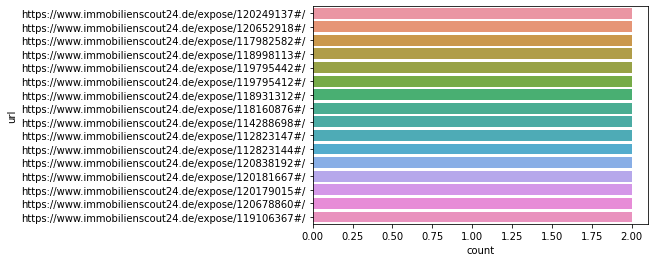

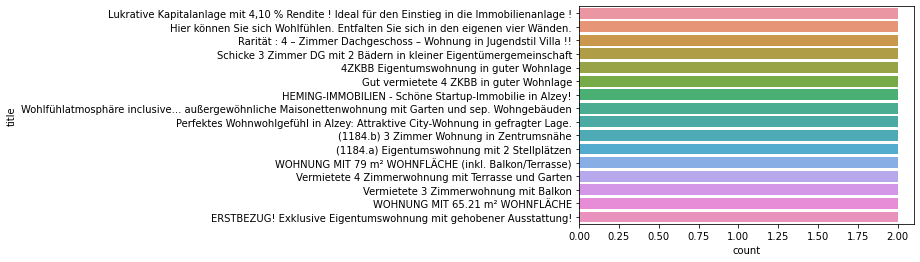

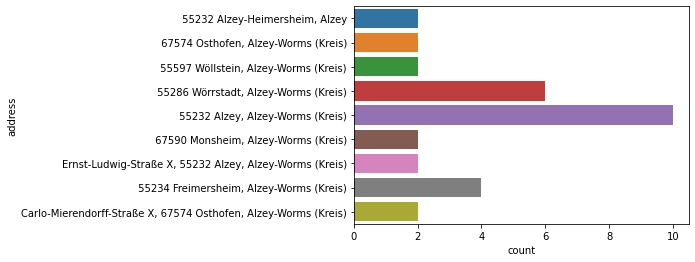

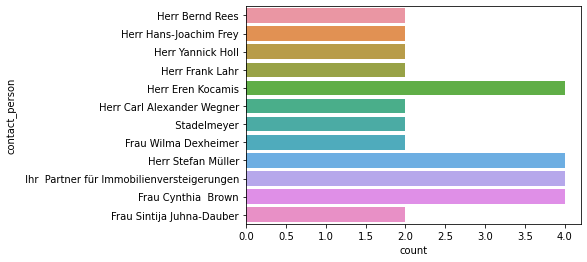

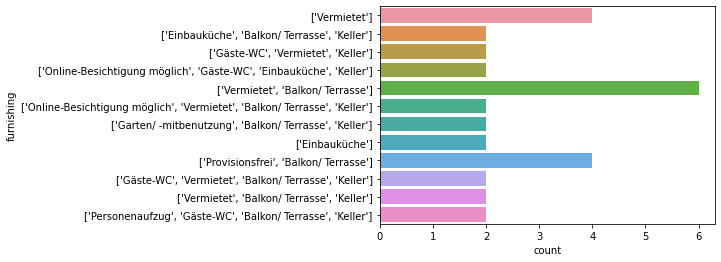

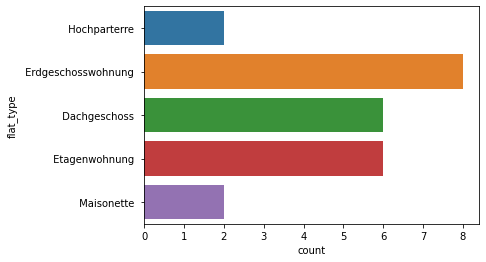

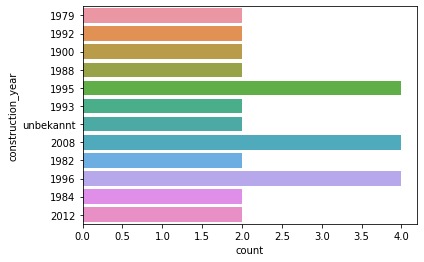

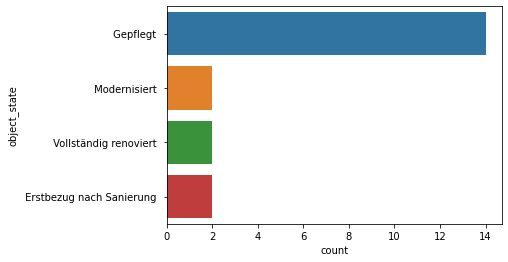

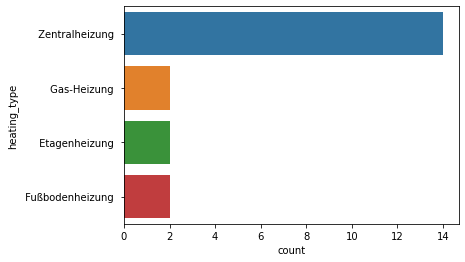

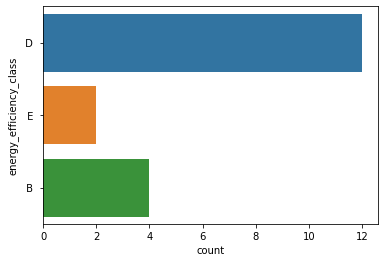

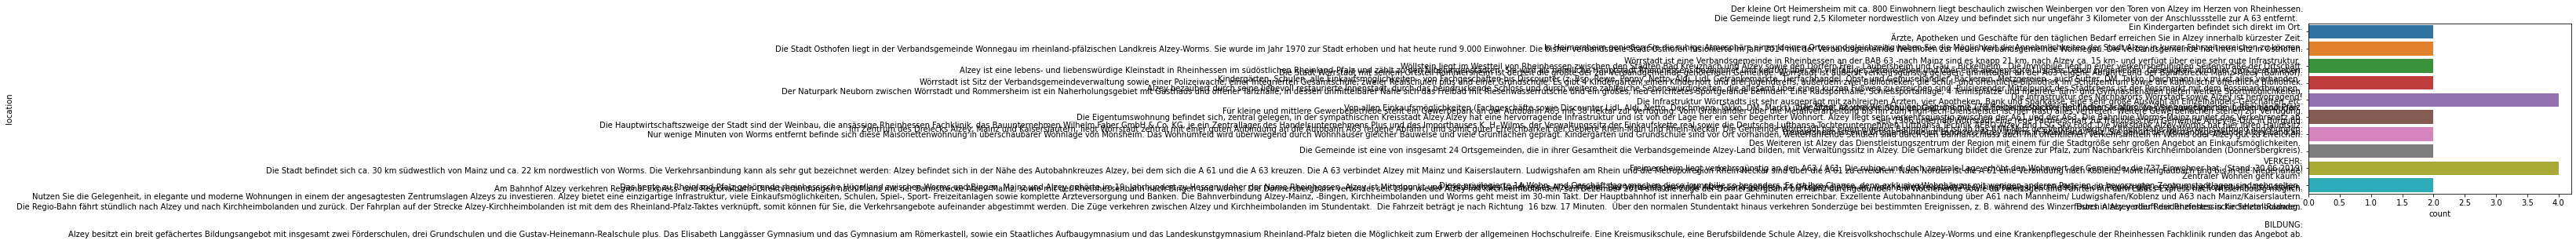

In [14]:
# TODO fix usage of list
# TODO data needs to be fixed
for features in df_base.dtypes[df_base.dtypes == 'object'].index:
    sns.countplot(y=features, data=df_base)
    plt.show()

## Data argmentation
Goal is to calculate the yearly ROI

In [15]:
df_finance = df_base[['url','price_purchase', 'living_area_m2', 'commission_buyer_rate']]
df_finance['price_per_m2'] = df_finance['price_purchase']
df_finance['notary_costs'] = notary_percentage * df_finance['price_purchase']

df_finance['land_registry_tax'] = land_registry_tax_percentage * df_finance['price_purchase']
df_finance['real_estate_transfer_tax'] = transfer_tax_percentage * df_finance['price_purchase']
df_finance['commission'] = df_finance['price_purchase'] * df_finance['commission_buyer_rate'] * 0.01 # TODO fix while parsing from scraper already
df_finance['total_buying_price'] = df_finance['price_purchase'] + df_finance['notary_costs'] + df_finance['land_registry_tax'] + df_finance['real_estate_transfer_tax'] + df_finance['commission']
df_finance['equity'] = equity_percentage * df_finance['total_buying_price']
df_finance['debt'] = df_finance['total_buying_price'] - df_finance['equity']
df_finance['interest_rate_monthly'] = interest_rate * df_finance['debt'] / 12
df_finance['mortgage_payment'] = mortgage_payment_rate * df_finance['debt']
df_finance['monthly_rent'] = rent_price_index * df_finance['living_area_m2']
df_finance['additional_costs'] = additional_costs_rate_per_m2 * df_finance['living_area_m2']
df_finance['cashflow'] = df_finance['monthly_rent'] - df_finance['interest_rate_monthly'] - df_finance['mortgage_payment'] - df_finance['additional_costs']
df_finance['ROI'] = (df_finance['cashflow'] * 12) / df_finance['equity'] 





In [19]:
df_finance.sort_values(by=['ROI'], ascending=False)

,url,price_purchase,commission_buyer_rate,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment,monthly_rent,additional_costs,cashflow,ROI
27,https://www.immobilienscout24.de/expose/120838192#/,113400,0.00,1701.000,567.000,5670.00,0.0000,121338.0000,24267.60000,97070.40000,80.892000,1941.408000,869.00,71.100,-1224.400000,-0.605449
11,https://www.immobilienscout24.de/expose/120838192#/,113400,0.00,1701.000,567.000,5670.00,0.0000,121338.0000,24267.60000,97070.40000,80.892000,1941.408000,869.00,71.100,-1224.400000,-0.605449
30,https://www.immobilienscout24.de/expose/120678860#/,96000,0.00,1440.000,480.000,4800.00,0.0000,102720.0000,20544.00000,82176.00000,68.480000,1643.520000,717.31,58.689,-1053.379000,-0.615291
14,https://www.immobilienscout24.de/expose/120678860#/,96000,0.00,1440.000,480.000,4800.00,0.0000,102720.0000,20544.00000,82176.00000,68.480000,1643.520000,717.31,58.689,-1053.379000,-0.615291
2,https://www.immobilienscout24.de/expose/117982582#/,159500,5.95,2392.500,797.500,7975.00,9490.2500,180155.2500,36031.05000,144124.20000,120.103500,2882.484000,1122.00,91.800,-1972.387500,-0.656896
18,https://www.immobilienscout24.de/expose/117982582#/,159500,5.95,2392.500,797.500,7975.00,9490.2500,180155.2500,36031.05000,144124.20000,120.103500,2882.484000,1122.00,91.800,-1972.387500,-0.656896
13,https://www.immobilienscout24.de/expose/120179015#/,178000,4.64,2670.000,890.000,8900.00,8259.2000,198719.2000,39743.84000,158975.36000,132.479467,3179.507200,1122.00,91.800,-2281.786667,-0.688948
29,https://www.immobilienscout24.de/expose/120179015#/,178000,4.64,2670.000,890.000,8900.00,8259.2000,198719.2000,39743.84000,158975.36000,132.479467,3179.507200,1122.00,91.800,-2281.786667,-0.688948
28,https://www.immobilienscout24.de/expose/120181667#/,198000,4.64,2970.000,990.000,9900.00,9187.2000,221047.2000,44209.44000,176837.76000,147.364800,3536.755200,1243.00,101.700,-2542.820000,-0.690211
12,https://www.immobilienscout24.de/expose/120181667#/,198000,4.64,2970.000,990.000,9900.00,9187.2000,221047.2000,44209.44000,176837.76000,147.364800,3536.755200,1243.00,101.700,-2542.820000,-0.690211


In [17]:
df_finance[(df_finance['cashflow'] > 0) ].sort_values(by=['ROI'], ascending=False)

,url,price_purchase,commission_buyer_rate,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment,monthly_rent,additional_costs,cashflow,ROI


In [18]:
df_finance[(df_finance['cashflow'] > 0) & (df_finance['equity'] <= 20000) ].sort_values(by=['ROI'], ascending=False)

,url,price_purchase,commission_buyer_rate,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment,monthly_rent,additional_costs,cashflow,ROI
